# Simple Random Forest Classifer for Land Use Land Cover Classification
*Connor Crowe*
**Objective:** This notebook trains a simple **Random Forest Classifier** to classify land use land cover (LULC) from aerial imagery. This goal is to generate a reasonable starting point to be improved upon with more complex models.

🔗 View more advanced U-Net architecture prediction: [Repository](https://github.com/connorcrowe/to-lulc-aiml)

**Dataset**: 
- **Aerial Imagery**: training and prediction aerial clipped from [Toronto Aerial Imagery GIS Map Server (2019)](https://gis.toronto.ca/arcgis/rest/services/basemap/cot_ortho/MapServer)
    - Training image size: 512px
- **Labelled Polygons**:  manually digitized from the aerial imagery above
    - Classes: road, building, vegetation

**Workflow**:
- Data Preprocessing - Training set masking of aerial image from labelled polygons, train test split
- Model: Random Forest with 100 estimators
- Prediction: Generates segmentation of larger aerial image


In [24]:
# IMPORTS AND RANDOM SEED
import rasterio
import rasterio.plot
from rasterio.mask import mask
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

RNG_SEED = 42

## Data Import
Import aerial image to be predicted and labelled polygons that give a training sample. 

**Note**: This approach takes polygons that represent only one class (all vegetation within the polygon, for example) and then clips the aerial image and uses the resulting mask as part of the training/test data. This approach is improved in future models to use entire labelled rasters.

In [25]:
RASTER_PATH = "input/aerial.tif"
VECTOR_PATH = "input/labels.geojson"

# Open Aerial Raster
raster = rasterio.open(RASTER_PATH)

# Scale RGB data to 0-1
scaled_image = raster.read().astype(np.float32) / 255.0  # Normalize pixel values
raster_shape = scaled_image.shape  # Save shape for reshaping later


# Open Labelled Vector
labelled_polygons = gpd.read_file(VECTOR_PATH)
labelled_polygons = labelled_polygons.to_crs(raster.crs)
labelled_polygons.head()

,id,class,geometry
0,1,vegetation,"MULTIPOLYGON (((-79.39273 43.65153, -79.39276 ..."
1,2,road,"MULTIPOLYGON (((-79.39372 43.65373, -79.39359 ..."
2,3,building,"MULTIPOLYGON (((-79.39395 43.65308, -79.39372 ..."
3,4,vegetation,"MULTIPOLYGON (((-79.39243 43.65287, -79.39222 ..."
4,5,building,"MULTIPOLYGON (((-79.39452 43.65286, -79.39446 ..."


### ***Optional:*** Visualize Aerial with Training Vectors

class
building      60
road          60
vegetation    60
Name: id, dtype: int64

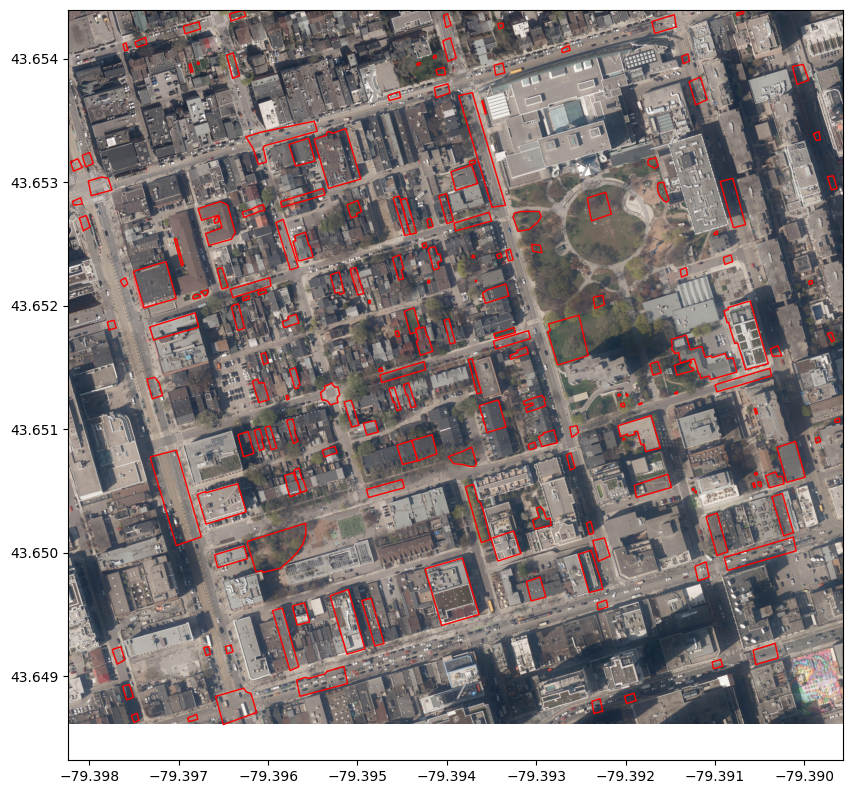

In [26]:
# Describe and show input data
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(raster, ax=ax)
labelled_polygons.plot(ax=ax, edgecolor="red", facecolor="none", lw=1)

labelled_polygons.groupby('class').id.count()

## Data Preparation
The data is prepared by:
- Masking the labelled polygons to the aerial image
- Splitting training and test data

In [27]:
X_list = []
y_list = []

# Mask aerial to labelled polygons
for class_type in labelled_polygons['class'].unique():
    class_polygons = labelled_polygons[labelled_polygons['class'] == class_type]

    image, transform = mask(raster, class_polygons.geometry, crop=True)
    image = image.astype(np.float32) / 255.0  # Scale cropped image
    bands = image.reshape(3, -1).T
    
    X_list.append(bands)
    y_list.extend([class_type] * bands.shape[0])

X = np.vstack(X_list)
y = pd.Series(y_list)

### Split Training and Testing Data

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED)
print(X_train.shape, y_train.shape)

## Fit Classifier
Fit the Random Forest Classifier to the training and test data.
- Experimentation showed little impact of modifying `n_estimators` and other model hyperparameters
- This is because the limitations lie in the training data and the model type, which is lacking spatial context

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=RNG_SEED)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate Accuracy

In [35]:
from sklearn.metrics import accuracy_score

y_pred_test = clf.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4427896053340073


## Predict Full Area
With the model fit the image can now be predicted.

**Note**: some training data appears in the prediction area which biases some areas of prediction. It is meant as an illustrative first prediction.

In [11]:
# Set up the visualization colors and class values
class_colors = {'road': [0.7, 0.7, 0.7],    # Gray
                'building': [0.8, 0.2, 0.2], # Red
                'vegetation': [0.2, 0.8, 0.2]} # Green

# Convert class names to numerical values for plotting
class_values = {name: i for i, name in enumerate(class_colors.keys())}
colors = [class_colors[class_name] for class_name in class_colors.keys()]

In [12]:
# Use scaled image for prediction
rows, cols = raster_shape[1], raster_shape[2]
input_image = scaled_image.reshape(3, -1).T
predictions = clf.predict(input_image)

numerical_predictions = np.array([class_values[pred] for pred in predictions])
pred_image = numerical_predictions.reshape((rows, cols))

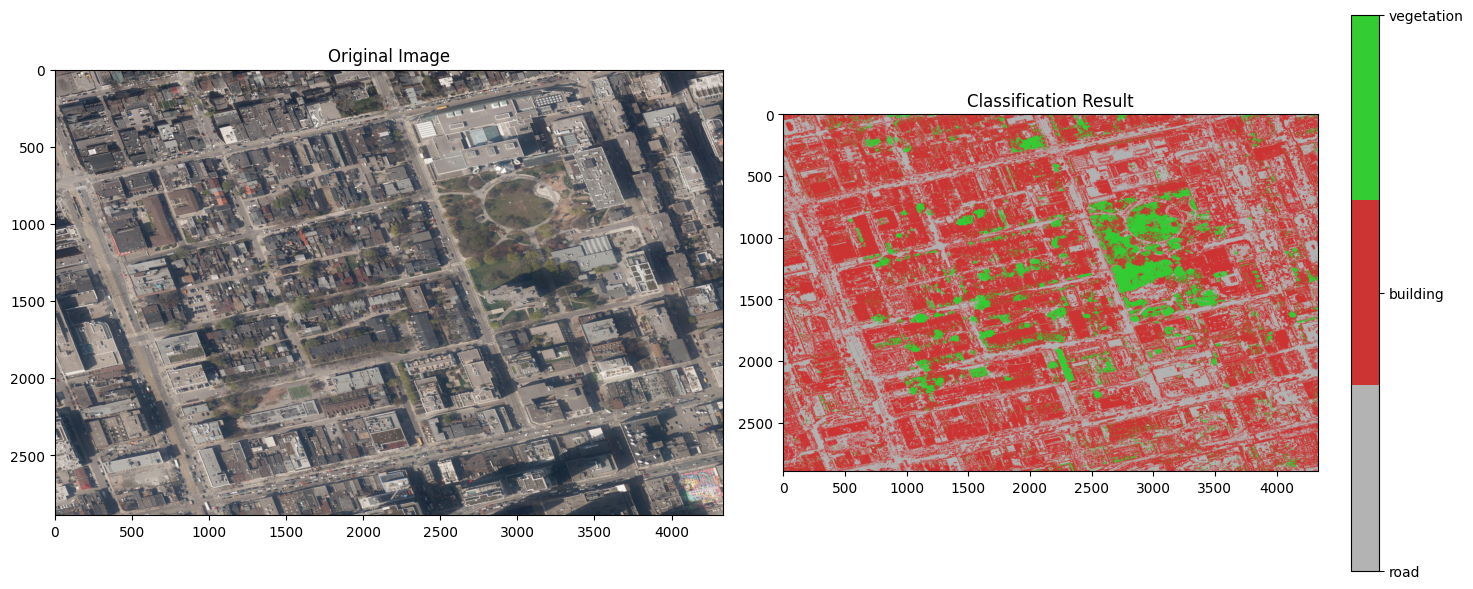

In [13]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot original image
rgb = scaled_image 
ax1.imshow(np.dstack((rgb[0], rgb[1], rgb[2])))
ax1.set_title('Original Image')

# Plot classification
im = ax2.imshow(pred_image, cmap=plt.cm.colors.ListedColormap(colors))
ax2.set_title('Classification Result')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, ticks=range(len(class_values)))
cbar.ax.set_yticklabels(class_values.keys())

plt.tight_layout()
plt.show()

## Export Result

In [23]:
# Rescale predictions for visualization/export
scaled_prediction = pred_image.astype(np.float32) * (255.0 / 3.0)
scaled_prediction = np.clip(scaled_prediction, 0, 255).astype(np.uint8)

# Use original metadata
metadata.update({
    "dtype": "uint8",  # Match predicted dtype
    "count": 1,        # Single band output
})

# Save the prediction as a GeoTIFF
output_path = f"result/{raster.shape[1]}out_res.tif"
with rasterio.open(output_path, "w", **metadata) as dst:
    dst.write(scaled_prediction, 1)
print(f"Prediction saved to {output_path}")

Prediction saved to result/4336out_res.tif
